Need to run 

`source code/tensorflow/bin/activate`

In [214]:
import numpy as np
from sklearn import metrics
import tensorflow as tf
import glob
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image 
import cPickle as pickle
from copy import deepcopy
import math

%matplotlib inline

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)
mnist.train.images.shape

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 784)

## Preprocessing images

In [147]:
image_files = glob.glob("../data/pineapples/*")
len(image_files)

1004

In [170]:
maxsize = (64,64)
arr = np.zeros((len(image_files), maxsize[0], maxsize[1]))
for num in range(len(image_files)):
    if num % 100 == 0: print num
    im = Image.open(image_files[num])
    data = np.array(im)

    # convert to one-hot
    data[data < 100] = 1
    data[data > 100] = 0
    data = data[:,:,1]

    # get bounding box
    new_im = Image.fromarray(data)
    lx, ly, rx, ry = new_im.getbbox()
    data_bbox = data[ly:ry, lx:rx]
    h, w = data_bbox.shape

    # add padding
    if w > h:
        pad = (w - h)/2 + 25
        if h + pad != w: data_pad = np.pad(data_bbox, ((pad,pad+1),(25,25)), mode='constant', constant_values=0)
        else: data_pad = np.pad(data_bbox, ((pad,pad),(25,25)), mode='constant', constant_values=0)
    else:
        pad = (h - w)/2 + 25
        if w + pad != h: data_pad = np.pad(data_bbox, ((25,25),(pad,pad+1)), mode='constant', constant_values=0)
        data_pad = np.pad(data_bbox, ((25,25),(pad,pad)), mode='constant', constant_values=0)

    # thumbnail
    small_im = Image.fromarray(data_pad)
    small_im.thumbnail(maxsize, Image.ANTIALIAS)
    assert(np.array(small_im).shape == maxsize)
    
    # save to array
    data_small = np.array(small_im)
    data_small[data_small < 0.5] = 0
    data_small[data_small > 0.5] = 1
    arr[num] = np.array(data_small)

0
100
200
300
400
500
600
700
800
900
1000


In [174]:
arr.shape

(1004, 64, 64)

In [173]:
pickle.dump(arr, open("../data/pineapple_array.pkl", 'w'))

In [ ]:
#plt.imshow(data_small*255)

## TensorFlow

In [175]:
data = pickle.load(open("../data/pineapple_array.pkl", 'r'))

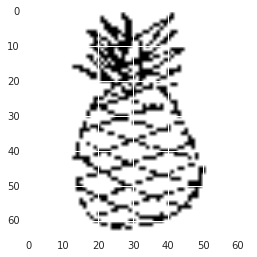

In [192]:
plt.imshow(data[1].flatten().reshape((64,64)))

In [273]:
# From https://github.com/pkmital/tensorflow_tutorials/blob/master/python/09_convolutional_autoencoder.py

def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
    
    
def autoencoder(input_shape=[None, 64*64],
                n_filters=[1, 10, 10, 4],
                filter_sizes=[3, 3, 3, 3],
                corruption=False):
    """Build a deep denoising autoencoder w/ tied weights.
    Parameters
    ----------
    input_shape : list, optional
        Description
    n_filters : list, optional
        Description
    filter_sizes : list, optional
        Description
    Returns
    -------
    x : Tensor
        Input placeholder to the network
    z : Tensor
        Inner-most latent representation
    y : Tensor
        Output reconstruction of the input
    cost : Tensor
        Overall cost to use for training
    Raises
    ------
    ValueError
        Description
    """
    # %%
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')

    # %%
    # ensure 2-d is converted to square tensor.
    if len(x.get_shape()) == 2:
        x_dim = np.sqrt(x.get_shape().as_list()[1])
        if x_dim != int(x_dim):
            raise ValueError('Unsupported input dimensions')
        x_dim = int(x_dim)
        x_tensor = tf.reshape(
            x, [-1, x_dim, x_dim, n_filters[0]])
    elif len(x.get_shape()) == 4:
        x_tensor = x
    else:
        raise ValueError('Unsupported input dimensions')
    current_input = x_tensor

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        shapes.append(current_input.get_shape().as_list())
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()

    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        output = lrelu(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.stack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x_tensor))

    # %%
    return {'x': x, 'z': z, 'y': y, 'cost': cost}

In [235]:
data_test[0:10,:].shape

(10, 64, 64)

In [278]:
layers = tf.contrib.layers
learn = tf.contrib.learn

# load data
data_flat = np.reshape(data, (1004,4096))
mean_img = np.mean(data_flat, axis=0)

data_train = data_flat[1:800,:]
data_test = data_flat[800:,:]

ae = autoencoder()

# %%
learning_rate = 2e-3
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# %%
# Fit all training data
batch_size = 50
n_epochs = 100
learning_rate = 8e-4

# n_filters = [1,10,10,10]
# filter_sizes = [3,3,3,3]
# learning_rate = 2e-3

for epoch_i in range(n_epochs):
    data_rand = deepcopy(data_flat)
    np.random.shuffle(data_rand)
    if n_epochs == 50: 
        learning_rate = learning_rate/10
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])
    for batch_i in range(data_rand.shape[0] // batch_size):
        start = batch_i*batch_size
        end = start + batch_size
        batch_xs = data_rand[start:end,:]
        train = batch_xs - mean_img
        sess.run(optimizer, feed_dict={ae['x']: train})
    if epoch_i % 5 == 0:
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train}))

(0, 16107.614)
(5, 14030.627)
(10, 12764.324)
(15, 13172.619)
(20, 12870.599)
(25, 13183.515)
(30, 13043.389)
(35, 11599.047)
(40, 12461.705)
(45, 12364.742)
(50, 12085.157)
(55, 12723.719)
(60, 12769.252)
(65, 11388.377)
(70, 11754.289)
(75, 11416.232)
(80, 11830.537)
(85, 11531.748)
(90, 11767.758)
(95, 12100.361)


(10, 64, 64, 1)


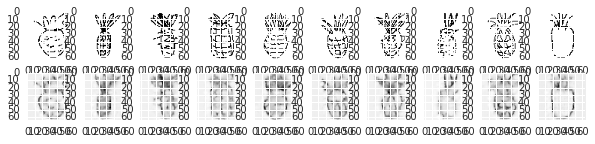

In [277]:
# %%
# Plot example reconstructions
n_examples = 10
indices = np.arange(data_test.shape[0])
np.random.shuffle(indices)
test_xs = data_test[indices[:n_examples],:]
test_xs_norm = test_xs - mean_img
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
print(recon.shape)
fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
for example_i in range(n_examples):
    axs[0][example_i].imshow(
        np.reshape(test_xs[example_i, :], (64, 64)))
    axs[1][example_i].imshow(
        np.reshape(
            np.reshape(recon[example_i, ...], (4096,)) + mean_img,
            (64, 64)))
fig.show()
plt.draw()

In [272]:
recon = sess.run(ae['z'], feed_dict={ae['x']: test_xs_norm})
print(recon.shape)

(10, 8, 8, 4)
